In [1]:
import time,os,json
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from train import *
from test import *
from utils.utils import *

import wandb
from tqdm import tqdm 

import torchvision
from torch.utils.data import Dataset

from einops import rearrange

import fasttext
import fasttext.util

import importlib
import main
importlib.reload(main)
from main import ConTextDataset
from main import ConTextTransformer

/anaconda/envs/xnap-project/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda
1.10.1
cuda
1.10.1


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)

cuda
1.10.1


In [11]:
wandb.login()
json_file = './splits/split_1.json'
img_dir = "./data/JPEGImages/"
txt_dir = "./ocr_labels/"
no_text_dir = "./no_text_images"

input_size = 256
data_transforms_train = torchvision.transforms.Compose([
            torchvision.transforms.RandomResizedCrop(input_size),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomRotation(15),
            torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            torchvision.transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
data_transforms_test = torchvision.transforms.Compose([
        torchvision.transforms.Resize(input_size),
        torchvision.transforms.CenterCrop(input_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [12]:
model = ConTextTransformer(image_size=input_size, num_classes=28, channels=3, dim=256, depth=2, heads=4, mlp_dim=512)

# Load the state dictionary
model.load_state_dict(torch.load('all_best_split1_resnet152.pth'))

<All keys matched successfully>

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()

ConTextTransformer(
  (resnet152): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [14]:
train_set = ConTextDataset(json_file, img_dir, txt_dir,no_text_dir,True, data_transforms_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=8)
test_set  = ConTextDataset(json_file, img_dir, txt_dir,no_text_dir, False, data_transforms_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=8)
test_loss_history = []

In [35]:
import torch
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def evaluate(model, data_loader, loss_history, device="cuda"):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    # Initialize arrays to store bad-predicted images and their predictions
    bad_predicted_images = [[] for _ in range(28)]  # Total number of classes
    bad_predicted_pred_images = [[] for _ in range(28)]

    # Arrays to collect true and predicted labels
    all_true_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for data_img, data_txt, txt_mask, target in data_loader:
            data_img = data_img.to(device)
            data_txt = data_txt.to(device)
            txt_mask = txt_mask.to(device)
            target = target.to(device)
            output = F.log_softmax(model(data_img, data_txt, txt_mask), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

            all_true_labels.extend(target.cpu().numpy())
            all_pred_labels.extend(pred.cpu().numpy())

            # Check if prediction is incorrect
            incorrect_mask = pred.ne(target)
            incorrect_indices = incorrect_mask.nonzero(as_tuple=False).squeeze()

            # Save bad-predicted images and their predictions
            for idx in incorrect_indices.flatten():
                bad_predicted_images[target[idx].item()].append(data_img[idx].cpu().numpy())
                bad_predicted_pred_images[target[idx].item()].append(pred[idx].item())

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

    return correct_samples / total_samples, bad_predicted_images, bad_predicted_pred_images, all_true_labels, all_pred_labels


In [ ]:
# Evaluate the model and get the true and predicted labels
accuracy, bad_predicted_images, bad_predicted_pred_images, all_true_labels, all_pred_labels = evaluate(model, test_loader, test_loss_history)

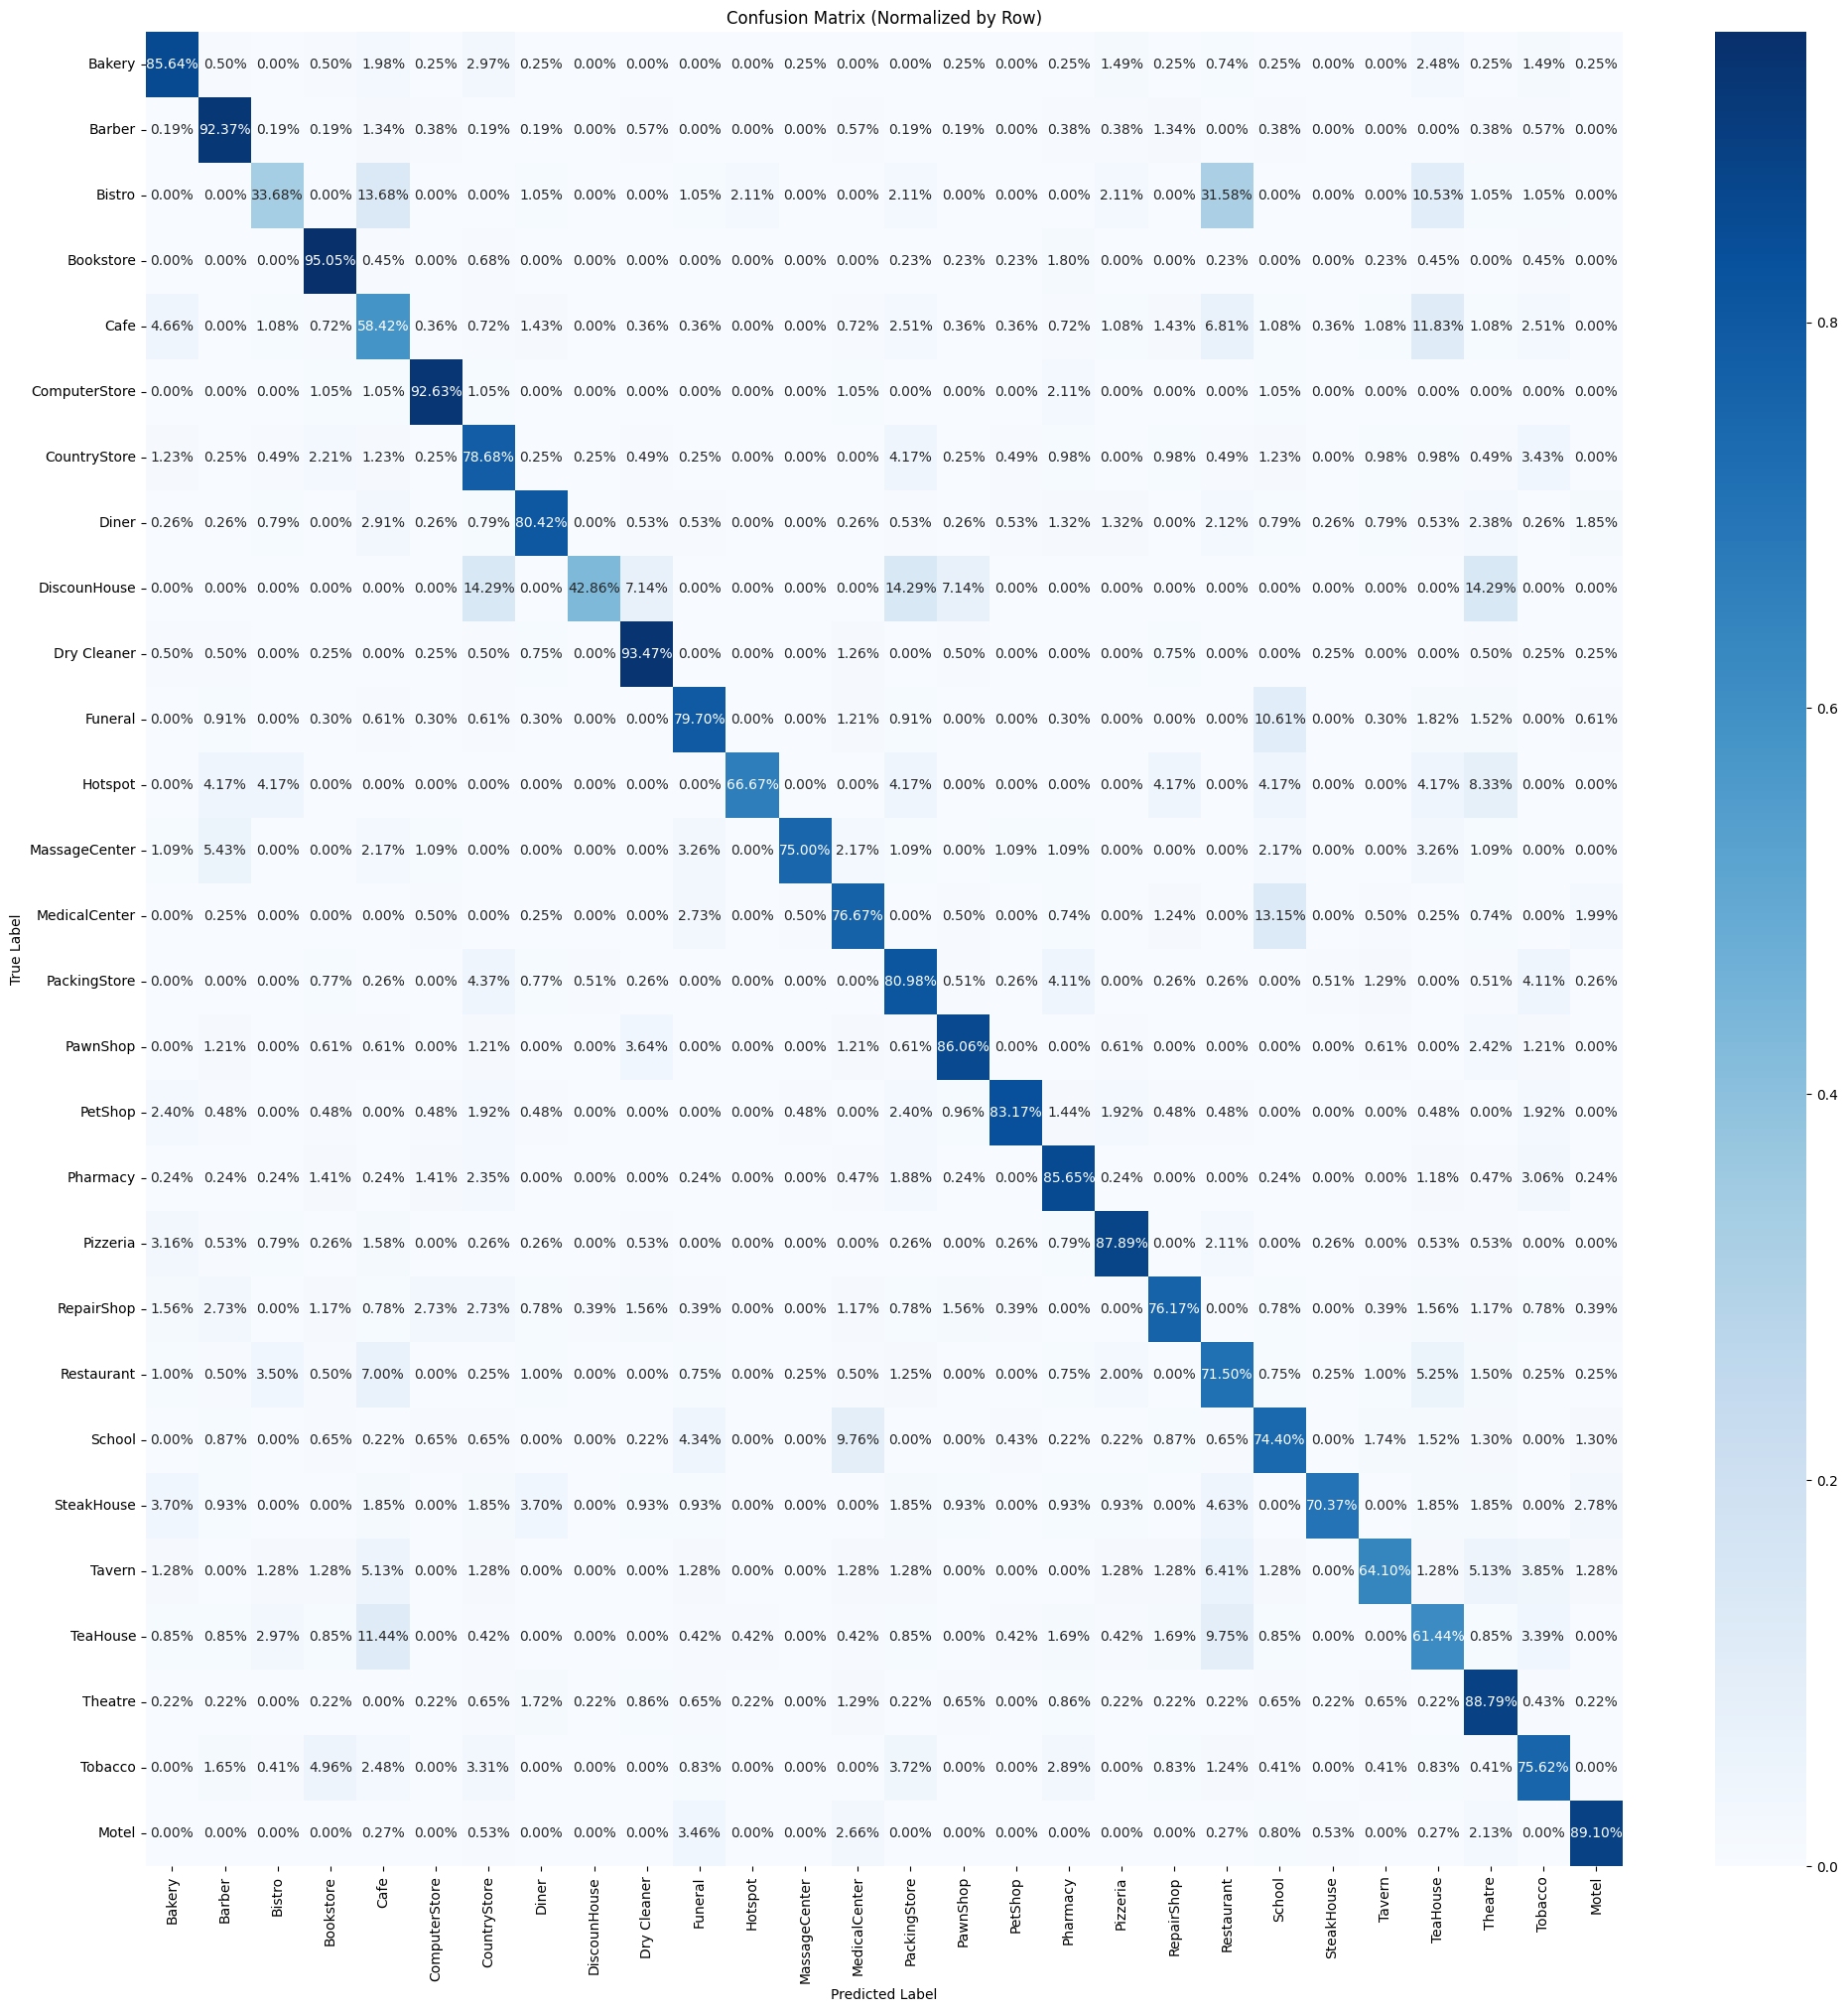

In [43]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)

# Normalize the confusion matrix by dividing each row by its sum
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

class_labels = {1: "Bakery", 2: "Barber", 3: "Bistro", 4: "Bookstore", 5: "Cafe", 6: "ComputerStore", 7: "CountryStore", 8: "Diner", 9: "DiscounHouse", 10: "Dry Cleaner", 11: "Funeral", 12: "Hotspot", 13: "MassageCenter", 14: "MedicalCenter", 15: "PackingStore", 16: "PawnShop", 17: "PetShop", 18: "Pharmacy", 19: "Pizzeria", 20: "RepairShop", 21: "Restaurant", 22: "School", 23: "SteakHouse", 24: "Tavern", 25: "TeaHouse", 26: "Theatre", 27: "Tobacco", 28: "Motel"}

# Plot the normalized confusion matrix
plt.figure(figsize=(24, 24))
num_classes = 28
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=[class_labels[i] for i in range(1, num_classes + 1)],
            yticklabels=[class_labels[i] for i in range(1, num_classes + 1)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Normalized by Row)')
plt.show()

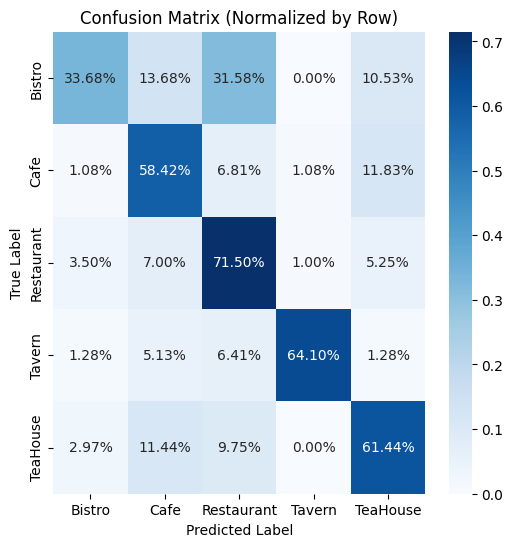

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#let's compute a small confusion matrix between bistro, cafe, Restaurant, Tavern and TeaHouse
bistro_predicted_labels = [33.68, 13.68, 31.58,0.00, 10.53 ]
cafe_predicted_labels = [1.08, 58.42, 6.81, 1.08, 11.83]
restaurant_predicted_labels = [3.5, 7.00, 71.5, 1.00, 5.25]
tavern_predicted_labels = [1.28, 5.13, 6.41, 64.1, 1.28]
teahouse_predicted_labels = [2.97, 11.44, 9.75, 0.00, 61.44]

#divide /100 the labels:
bistro_predicted_labels = np.array(bistro_predicted_labels)/100
cafe_predicted_labels = np.array(cafe_predicted_labels)/100
restaurant_predicted_labels = np.array(restaurant_predicted_labels)/100
tavern_predicted_labels = np.array(tavern_predicted_labels)/100
teahouse_predicted_labels = np.array(teahouse_predicted_labels)/100
#compute a confusion matrix (it is already normalized):
conf_matrix = np.array([bistro_predicted_labels, cafe_predicted_labels, restaurant_predicted_labels, tavern_predicted_labels, teahouse_predicted_labels])

labels_aux = {1: "Bistro", 2: "Cafe", 3: "Restaurant", 4: "Tavern", 5: "TeaHouse"}
# Plot the normalized confusion matrix
plt.figure(figsize=(6, 6))
num_classes = 5
sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=[labels_aux[i] for i in range(1, 6)],
            yticklabels=[labels_aux[i] for i in range(1, 6)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Normalized by Row)')
plt.show()



There are certain classes such as Bistro, Restaurant, Cafe or Tavern which tend to be confused among them due to their image similarity.

### Train-Test Number of instances of each class

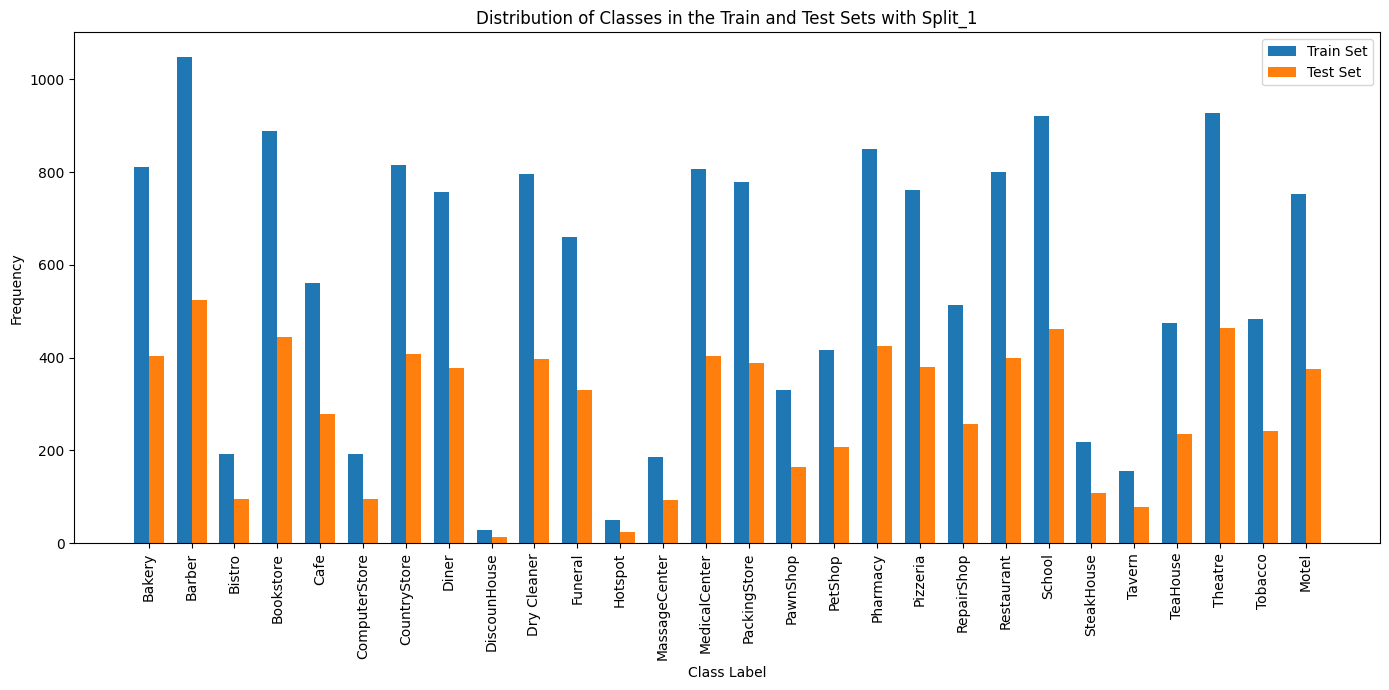

In [37]:
# Initialize arrays to store the counts for each class
class_counts_train = np.zeros(num_classes, dtype=int)
class_counts_test = np.zeros(num_classes, dtype=int)

# Collect class labels and count occurrences in the train set
for _, _, _, target in train_set:
    class_counts_train[target] += 1

# Collect class labels and count occurrences in the test set
for _, _, _, target in test_set:
    class_counts_test[target] += 1

# Plot the distribution
plt.figure(figsize=(14, 7))
bar_width = 0.35
indices = np.arange(1, num_classes + 1)

# Plot train set distribution
plt.bar(indices - bar_width/2, class_counts_train, bar_width, label='Train Set')

# Plot test set distribution
plt.bar(indices + bar_width/2, class_counts_test, bar_width, label='Test Set')

plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Classes in the Train and Test Sets with Split_1')
plt.xticks(indices, [class_labels[i] for i in range(1, num_classes + 1)], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

We can see that the relation between the number of images in the train and test dataset remains constant. Thus, the data is well splitted. Nevertheless, there are some classes with much more images than others, so the model might be a little biased to those classes with more images

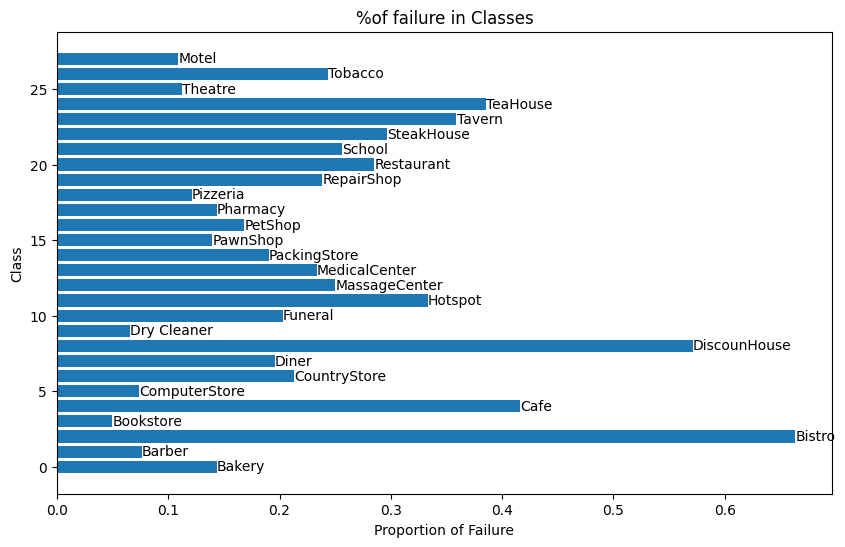

In [38]:
class_labels = {1: "Bakery", 2: "Barber", 3: "Bistro", 4: "Bookstore", 5: "Cafe", 6: "ComputerStore", 7: "CountryStore", 8: "Diner", 9: "DiscounHouse", 10: "Dry Cleaner", 11: "Funeral", 12: "Hotspot", 13: "MassageCenter", 14: "MedicalCenter", 15: "PackingStore", 16: "PawnShop", 17: "PetShop", 18: "Pharmacy", 19: "Pizzeria", 20: "RepairShop", 21: "Restaurant", 22: "School", 23: "SteakHouse", 24: "Tavern", 25: "TeaHouse", 26: "Theatre", 27: "Tobacco", 28: "Motel"}

total_samples = len(test_loader.dataset)
worst_classes = np.argsort([len(images) for images in bad_predicted_images])[::-1]
failure_proportions = [len(bad_predicted_images[i]) / class_counts_test[i] for i in worst_classes]

plt.figure(figsize=(10, 6))
plt.barh(worst_classes, failure_proportions)
plt.xlabel('Proportion of Failure')
plt.ylabel('Class')
plt.title('%of failure in Classes')

# Add annotations with class labels and slightly adjust position for better visibility
for i, (failure_prop, class_id) in enumerate(zip(failure_proportions, worst_classes)):
  plt.text(failure_prop + 0.00015, class_id, class_labels[class_id + 1], va='center')

plt.show()

Some of the classes which fail the most, are the ones with less instances.

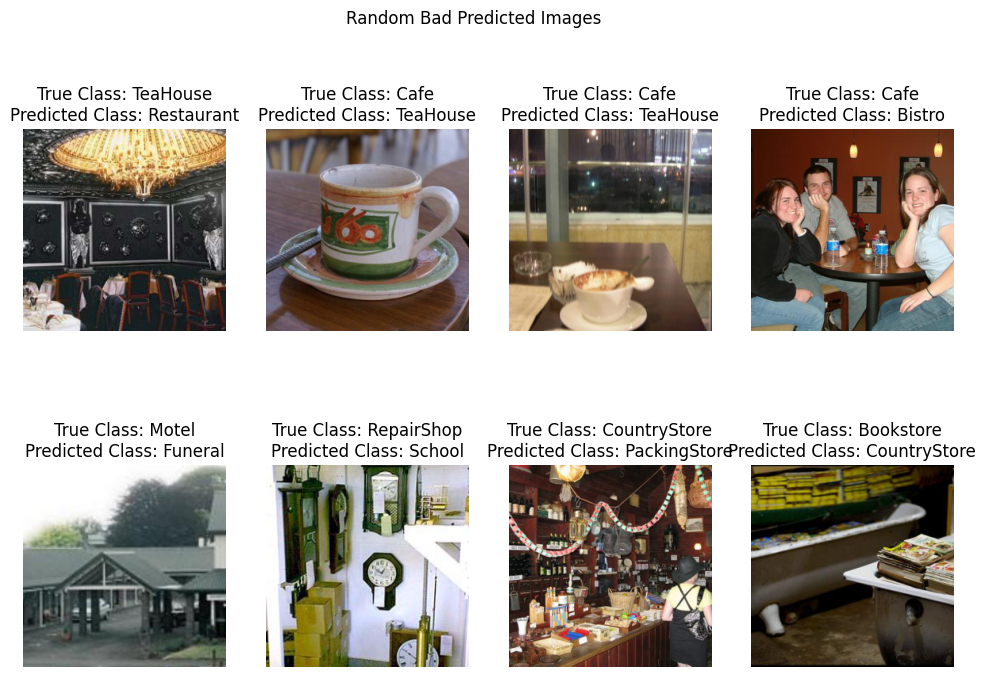

In [39]:
# Plot 8 random bad predicted images
plt.figure(figsize=(12, 8))
# Mean and std used in normalization (Let's unnormalize!)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def unnormalize(tensor, mean, std):
    """
    Unnormalize a tensor given the mean and std deviation.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

for i in range(8):
    class_idx = np.random.choice(28)  # We get a random class
    images = bad_predicted_images[class_idx]
    
    if len(images) == 0:
        continue  # Skip if no bad predicted images for this class
    
    random_image_idx = np.random.choice(len(images))  # We get a random bad_predicted image index
    random_image = images[random_image_idx]
    
    # Ensure the image is a tensor
    if isinstance(random_image, np.ndarray):
        random_image = torch.tensor(random_image)
        
    # Unnormalize the image
    unnormalized_image = unnormalize(random_image.clone(), mean, std)
    
    # Convert to numpy array
    unnormalized_image = unnormalized_image.numpy()
    unnormalized_image = np.transpose(unnormalized_image, (1, 2, 0))  # Transpose to HWC format if needed
    
    # Get the predicted class index
    predicted_class_idx = bad_predicted_pred_images[class_idx][random_image_idx]
    
    plt.subplot(2, 4, i + 1)
    if unnormalized_image.shape[2] == 1:
        unnormalized_image = unnormalized_image.squeeze()  # Remove the last dimension for grayscale images

    plt.imshow(unnormalized_image, cmap='gray' if unnormalized_image.ndim == 2 else None)
    plt.axis('off')
    plt.title(f'True Class: {class_labels[class_idx+1]}\nPredicted Class: {class_labels[predicted_class_idx+1]}')
plt.suptitle('Random Bad Predicted Images')
plt.show()
